<a href="https://colab.research.google.com/github/hanmaegeo/Forest-Cover-Type-Prediction/blob/main/project_baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# W207 Project Baseline
## Forest Cover Type Prediction

**Authors:** Raul Merino, Hannah George, and Rohan Mendiratta

[Kaggle Competition Link](https://www.kaggle.com/c/forest-cover-type-prediction)

## Introduction

In this project we will attempt to predict the forecast cover type from cartographic data. 

The seven types of forest covers are:

*   Spruce/Fir
*   Lodgepole Pine
*   Ponderosa Pine
*   Cottonwood/Willow
*   Aspen
*   Douglas-fir
*   Krummholz

And the data fields we will use attempt to predict these forest cover types are:
*   Elevation - Elevation in meters.
*   Aspect - Aspect in degrees azimuth.
*   Slope - Slope in degrees.
*   Horizontal_Distance_To_Hydrology - Hoizontal distance to nearest surface water features.
*   Vertical_Distance_To_Hydrology - Vertical distance to nearest surface water features.
*   Horizontal_Distance_To_Roadways - Horzontal distance to nearest roadway.
*   Hillshade_9am (0 to 255 index) - Hillshade index at 9am, summer solstice.
*   Hillshade_Noon (0 to 255 index) - Hillshade index at noon, summer solstice.
*   Hillshade_3pm (0 to 255 index) - Hillshade index at 3pm, summer solstice.
*   Horizontal_Distance_To_Fire_Points - Horzontal distance to nearest wildfire ignition points.
*   Wilderness_Area (4 binary columns, 0 = absence or 1 = presence) - Wilderness area designation.
*   Soil_Type (40 binary columns, 0 = absence or 1 = presence) - Soil Type designation.

The wilderness areas are:

* Rawah Wilderness Area
* Neota Wilderness Area
* Comanche Peak Wilderness Area
* Cache la Poudre Wilderness Area

## Project Setup

### Imports

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, PredefinedSplit
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.decomposition import PCA


### Constants

In [2]:
CLASSES = [
    "Spruce/Fir",
    "Lodgepole Pine",
    "Ponderosa Pine",
    "Cottonwood/Willow",
    "Aspen",
    "Douglas-fir",
    "Krummholz"
]

CONTINOUS_COLUMNS = [
  'Elevation',
  'Aspect',
  'Slope',
  'Horizontal_Distance_To_Hydrology',
  'Vertical_Distance_To_Hydrology',
  'Horizontal_Distance_To_Roadways',
  'Hillshade_9am',
  'Hillshade_Noon',
  'Hillshade_3pm',
  'Horizontal_Distance_To_Fire_Points'
]

WILDERNESS_AREAS = [
    "Rawah Wilderness Area",
    "Neota Wilderness Area",
    "Comanche Peak Wilderness Area",
    "Cache la Poudre Wilderness Area"
]

### Load in Data

In [3]:
# Read in CSV.
github_data_link = 'https://raw.githubusercontent.com/hanmaegeo/Forest-Cover-Type-Prediction/main/data.csv'

# The column Id isn't useful for our purposes so we can drop it.
dataset = pd.read_csv(github_data_link).drop('Id', axis=1)

In [4]:
# Ensure data is loaded in correctly.
dataset.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,2596,51,3,258,0,510,221,232,148,6279,...,0,0,0,0,0,0,0,0,0,5
1,2590,56,2,212,-6,390,220,235,151,6225,...,0,0,0,0,0,0,0,0,0,5
2,2804,139,9,268,65,3180,234,238,135,6121,...,0,0,0,0,0,0,0,0,0,2
3,2785,155,18,242,118,3090,238,238,122,6211,...,0,0,0,0,0,0,0,0,0,2
4,2595,45,2,153,-1,391,220,234,150,6172,...,0,0,0,0,0,0,0,0,0,5


### Train/Dev/Test Split

In [5]:
# Split features and labels.
x = dataset.loc[:, dataset.columns != 'Cover_Type']
y = dataset['Cover_Type']

# Split data into train, dev, and test - shuffle and use seed to create reproducable split.
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=0, train_size=.8)
dev_size = int(len(x_train) * 0.2)

# Create split of train and dev to use for for Grid Search.
train_idxs = np.full(len(x_train) - dev_size, -1)
dev_idxs = np.full(dev_size, 0)
test_fold = np.append(train_idxs, dev_idxs)

ps = PredefinedSplit(test_fold=test_fold)

# Printing out sizes for reference.
print(f"Number of Training Samples: {len(train_idxs)}")
print(f"Number of Dev Samples: {len(dev_idxs)}")
print(f"Number of Testing Samples: {x_test.shape[0]}")

Number of Training Samples: 9677
Number of Dev Samples: 2419
Number of Testing Samples: 3024


## Exploratory Data Analysis

In [6]:
r, c = x_train.shape
print(f'There are {r} training examples and {c} features per training example')
dataset.describe()

There are 12096 training examples and 54 features per training example


,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
count,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,...,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000
mean,2749.322553,156.676653,16.501587,227.195701,51.076521,1714.023214,212.704299,218.965608,135.091997,1511.147288,...,0.045635,0.040741,0.001455,0.006746,0.000661,0.002249,0.048148,0.043452,0.030357,4.000000
std,417.678187,110.085801,8.453927,210.075296,61.239406,1325.066358,30.561287,22.801966,45.895189,1099.936493,...,0.208699,0.197696,0.038118,0.081859,0.025710,0.047368,0.214086,0.203880,0.171574,2.000066
min,1863.000000,0.000000,0.000000,0.000000,-146.000000,0.000000,0.000000,99.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2376.000000,65.000000,10.000000,67.000000,5.000000,764.000000,196.000000,207.000000,106.000000,730.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
50%,2752.000000,126.000000,15.000000,180.000000,32.000000,1316.000000,220.000000,223.000000,138.000000,1256.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000
75%,3104.000000,261.000000,22.000000,330.000000,79.000000,2270.000000,235.000000,235.000000,167.000000,1988.250000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000
max,3849.000000,360.000000,52.000000,1343.000000,554.000000,6890.000000,254.000000,254.000000,248.000000,6993.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,7.000000


There aren't any empty values, as all of the columns have counts equal to the number of rows. There are 40 Soil Types, and 4 Wilderness Areas.
Soil_Type7 and Soil_Type15 have standard deviations of 0 which means they are constant, and it seems in both cases the values are 0. Since these are Dummy variables this means that no trees in our database have those soil types.

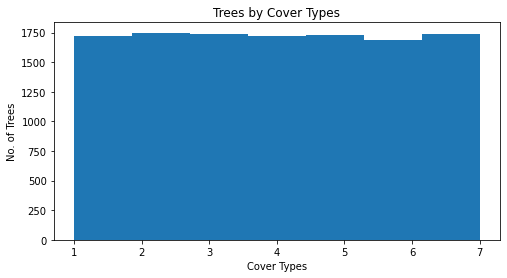

In [7]:
# Create histogram showing distribution of labels.
fig, ax = plt.subplots(figsize=(8,4))

ax.hist(y_train, bins=y_train.max())

ax.set_xlabel("Cover Types")
ax.set_ylabel("No. of Trees")
ax.set_title("Trees by Cover Types")
plt.show()

As it can be seen in the previous histogram, the cover types are evenly distributed in our dataset.

In [8]:
x_train['Total_Soils'] = 0
for i in range(1, 40):
    x_train['Total_Soils'] += x_train[f'Soil_Type{i}']
x_train['Total_Areas'] = 0
for i in range(1, 4):
    x_train['Total_Areas'] += x_train[f'Wilderness_Area{i}']

# Check the max values, they should be 1 if these variables are unique.
if x_train['Total_Soils'].max() == 1:
    print('There are no trees with more than 1 soil type')
else:
    print('There are some trees with more than 1 soil type')
if x_train['Total_Areas'].max() == 1:
    print('There are no trees in more than 1 wilderness area')
else:
    print('There are some trees that are in more than 1 wilderness area')
    
x_train = x_train.drop(columns=['Total_Soils', 'Total_Areas'])

There are no trees with more than 1 soil type
There are no trees in more than 1 wilderness area


We can also check that the soil types and wilderness area are indeed categorial variables broken down into dummy variables, and that it's not possible for a specific tree to have more than 1 soil type, or to be in more than 1 area.

In [9]:
# Calculate correlations between features. Create heatmap.
data_corr = x_train.corr()
data_corr.style.background_gradient(cmap='coolwarm').format(precision=2).set_properties(**{'font-size': '6pt'})


/usr/local/lib/python3.7/dist-packages/pandas/io/formats/style.py:2813: RuntimeWarning: All-NaN slice encountered
  smin = np.nanmin(gmap) if vmin is None else vmin
/usr/local/lib/python3.7/dist-packages/pandas/io/formats/style.py:2814: RuntimeWarning: All-NaN slice encountered
  smax = np.nanmax(gmap) if vmax is None else vmax


,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area1,Wilderness_Area2,Wilderness_Area3,Wilderness_Area4,Soil_Type1,Soil_Type2,Soil_Type3,Soil_Type4,Soil_Type5,Soil_Type6,Soil_Type7,Soil_Type8,Soil_Type9,Soil_Type10,Soil_Type11,Soil_Type12,Soil_Type13,Soil_Type14,Soil_Type15,Soil_Type16,Soil_Type17,Soil_Type18,Soil_Type19,Soil_Type20,Soil_Type21,Soil_Type22,Soil_Type23,Soil_Type24,Soil_Type25,Soil_Type26,Soil_Type27,Soil_Type28,Soil_Type29,Soil_Type30,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40
Elevation,1.00,-0.01,-0.32,0.41,0.12,0.58,0.09,0.22,0.10,0.44,0.33,0.26,0.35,-0.78,-0.22,-0.15,-0.31,-0.12,-0.14,-0.19,nan,0.00,-0.01,-0.36,-0.04,0.02,0.04,-0.14,nan,-0.07,-0.20,-0.04,0.03,0.01,0.03,0.14,0.16,0.10,0.01,0.02,0.04,-0.00,0.16,0.05,0.09,0.17,0.12,0.02,0.12,0.04,0.07,0.33,0.30,0.30
Aspect,-0.01,1.00,0.02,0.04,0.05,0.07,-0.59,0.33,0.63,-0.05,-0.12,0.03,0.03,0.07,-0.03,-0.02,-0.07,0.02,-0.00,-0.00,nan,0.00,-0.02,0.11,-0.04,-0.04,0.03,0.01,nan,0.04,0.03,-0.04,0.01,-0.02,0.02,0.03,0.04,0.01,-0.00,-0.01,0.02,0.03,-0.06,-0.09,0.01,0.00,0.01,0.01,-0.01,0.00,-0.04,0.04,-0.03,0.02
Slope,-0.32,0.02,1.00,-0.06,0.27,-0.28,-0.19,-0.61,-0.33,-0.24,-0.15,-0.07,-0.11,0.29,0.10,-0.08,0.27,0.10,0.07,-0.04,nan,-0.01,-0.02,0.25,-0.11,-0.12,0.12,-0.05,nan,-0.06,-0.13,-0.07,-0.05,-0.07,-0.03,-0.08,-0.18,0.02,0.01,-0.03,0.01,0.03,-0.08,0.12,-0.08,-0.15,0.07,-0.03,-0.05,-0.00,0.00,-0.15,0.05,-0.04
Horizontal_Distance_To_Hydrology,0.41,0.04,-0.06,1.00,0.65,0.20,-0.03,0.08,0.08,0.16,-0.01,0.09,0.20,-0.24,-0.08,0.02,-0.09,-0.06,-0.03,0.02,nan,0.00,-0.01,-0.11,0.03,0.04,0.01,-0.11,nan,-0.09,-0.16,-0.02,-0.04,-0.06,-0.03,-0.01,-0.09,0.05,-0.01,0.03,0.06,0.03,0.02,-0.04,0.06,0.14,0.07,0.08,-0.01,0.08,-0.01,0.14,0.07,0.24
Vertical_Distance_To_Hydrology,0.12,0.05,0.27,0.65,1.00,0.01,-0.09,-0.14,-0.04,-0.01,-0.12,0.02,0.07,0.02,-0.03,0.00,0.07,-0.01,0.02,0.09,nan,-0.01,-0.01,0.02,-0.03,-0.03,0.07,-0.09,nan,-0.07,-0.16,-0.04,-0.04,-0.06,-0.02,-0.06,-0.14,0.02,-0.01,-0.01,0.04,0.06,-0.06,0.01,0.00,0.02,0.08,0.04,-0.02,0.02,-0.02,-0.01,0.06,0.23
Horizontal_Distance_To_Roadways,0.58,0.07,-0.28,0.20,0.01,1.00,-0.01,0.24,0.18,0.48,0.36,-0.08,0.13,-0.44,-0.12,-0.09,-0.16,-0.09,-0.09,-0.14,nan,0.02,-0.02,-0.21,-0.08,0.08,-0.00,-0.07,nan,-0.02,-0.08,-0.04,0.06,0.05,-0.01,0.11,0.13,0.02,-0.01,0.02,0.02,-0.01,0.26,-0.07,0.03,0.03,0.05,0.02,0.07,0.03,0.06,0.20,0.12,0.15
Hillshade_9am,0.09,-0.59,-0.19,-0.03,-0.09,-0.01,1.00,-0.02,-0.78,0.07,0.17,-0.01,-0.02,-0.13,0.03,0.05,0.25,0.04,-0.05,0.02,nan,0.00,0.01,-0.38,0.03,0.05,0.01,-0.01,nan,-0.01,-0.02,0.03,-0.01,0.01,-0.01,-0.00,-0.00,-0.05,0.01,0.02,-0.01,-0.06,0.05,0.16,-0.02,0.02,-0.05,0.01,0.03,0.01,0.01,0.01,0.03,-0.02
Hillshade_Noon,0.22,0.33,-0.61,0.08,-0.14,0.24,-0.02,1.00,0.62,0.12,-0.01,0.04,0.19,-0.20,-0.04,0.09,-0.10,0.14,-0.09,0.03,nan,0.01,0.00,-0.28,0.04,0.05,0.00,0.01,nan,0.05,0.09,0.02,0.04,0.02,0.03,0.06,0.13,-0.05,-0.00,0.04,0.03,0.01,-0.00,-0.15,0.05,0.09,-0.02,0.04,0.03,0.03,-0.03,0.11,-0.05,-0.01
Hillshade_3pm,0.10,0.63,-0.33,0.08,-0.04,0.18,-0.78,0.62,1.00,0.04,-0.12,0.04,0.13,-0.05,-0.06,0.02,-0.30,0.02,-0.02,0.01,nan,0.00,-0.00,0.13,0.02,0.01,-0.03,0.02,nan,0.04,0.08,0.00,0.03,0.01,0.03,0.05,0.10,0.01,-0.01,0.01,0.02,0.05,-0.03,-0.22,0.05,0.06,0.02,0.02,-0.00,0.01,-0.03,0.07,-0.06,0.02
Horizontal_Distance_To_Fire_Points,0.44,-0.05,-0.24,0.16,-0.01,0.48,0.07,0.12,0.04,1.00,0.43,0.05,0.00,-0.42,-0.11,-0.11,-0.15,-0.06,-0.07,-0.11,nan,0.03,-0.01,-0.21,-0.03,0.19,-0.05,-0.08,nan,0.01,-0.07,0.21,0.01,0.09,-0.01,0.05,0.08,0.05,0.02,0.04,0.01,-0.00,0.25,0.03,-0.02,0.02,0.05,-0.01,0.01,-0.01,0.03,0.09,0.04,0.14


If we look at the correlation matrix we can notice right away that Soil_Type7 and Soil_Type15 have NaN as their values. This makes sense since they all have values of 0, which given the correlation formula would make the denominator 0 as well.

We can also see some important correlation values, such as Elevation and Wilderness_Area4, which a very high negative correlation, which likely means that most of that area has low elevation, while Horizontal_Distance_To_Roadways has a relatively high positive correlation, which we can interpret as the elevation increasing the further away a tree is from a roadway.

Hillshade_9am and Hillshade_3pm seem to be very negatively correlated, the difference likely comes from the fact that the sun is in opposites sides at each of those times.

We don't observe any major correlation with the over type, which makes sense since Cover_Type is a categorical variable, so there's no real order between them.

In [10]:
# One hot encode labels .
cover_dummies = pd.get_dummies(y_train).rename(columns=dict(zip(np.arange(1,8), CLASSES)))

# Concat with training set.
new_dataset = pd.concat([cover_dummies, x_train], axis=1)

# Calculate correlations between features and labels. Create heatmap.
data_corr = new_dataset.corr()
data_corr[cover_dummies.columns].style.background_gradient(cmap='coolwarm').format(precision=2).set_properties(**{'font-size': '6pt'})


,Spruce/Fir,Lodgepole Pine,Ponderosa Pine,Cottonwood/Willow,Aspen,Douglas-fir,Krummholz
Spruce/Fir,1.00,-0.17,-0.17,-0.17,-0.17,-0.16,-0.17
Lodgepole Pine,-0.17,1.00,-0.17,-0.17,-0.17,-0.17,-0.17
Ponderosa Pine,-0.17,-0.17,1.00,-0.17,-0.17,-0.17,-0.17
Cottonwood/Willow,-0.17,-0.17,-0.17,1.00,-0.17,-0.16,-0.17
Aspen,-0.17,-0.17,-0.17,-0.17,1.00,-0.16,-0.17
Douglas-fir,-0.16,-0.17,-0.17,-0.16,-0.16,1.00,-0.17
Krummholz,-0.17,-0.17,-0.17,-0.17,-0.17,-0.17,1.00
Elevation,0.37,0.17,-0.34,-0.51,0.03,-0.32,0.60
Aspect,0.01,-0.02,0.06,-0.07,-0.08,0.09,0.00
Slope,-0.16,-0.15,0.20,0.10,0.01,0.12,-0.12


By looking at just the correlation of each indididual cover type with the rest of our variables we can see that some of them have clear relationships between them. Such as trees with Krummholz having high elevation, while those with Cottonwood/Willow having low elevation given their high negstive correlation.

We can also see that certain wilderness areas and soil types have more noticeable correlations with the cover types, such as Cottonwood/Willow with Cache la Poudre Wilderness Area and soil type 3.

In [11]:
data_chart = pd.DataFrame(index=np.arange(0, r),columns=['Wilderness_Area','Soil_Type','Cover_Type'])

for i in range(4):
    data_chart['Wilderness_Area'] = np.where(x_train[f'Wilderness_Area{i+1}'],i+1,data_chart['Wilderness_Area'])
    
for i in range(40):
    data_chart['Soil_Type'] = np.where(x_train[f'Soil_Type{i+1}'],i+1,data_chart['Soil_Type'])

data_chart['Cover_Type'] = y_train.tolist()

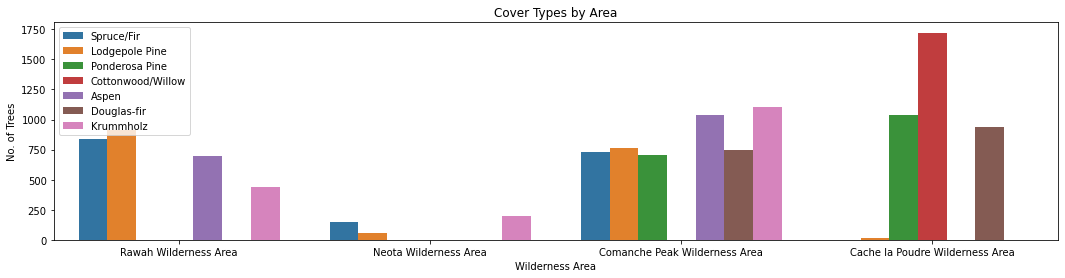

In [12]:
# plot for Category1
fig, ax = plt.subplots(figsize=(18, 4))
sns.countplot(x="Wilderness_Area", hue="Cover_Type", data=data_chart, ax=ax)
ax.legend(CLASSES, loc='upper left')
ax.set_xlabel("Wilderness Area")
ax.set_xticks(np.arange(4))
ax.set_xticklabels(WILDERNESS_AREAS)
ax.set_ylabel("No. of Trees")
ax.set_title("Cover Types by Area")
plt.show()

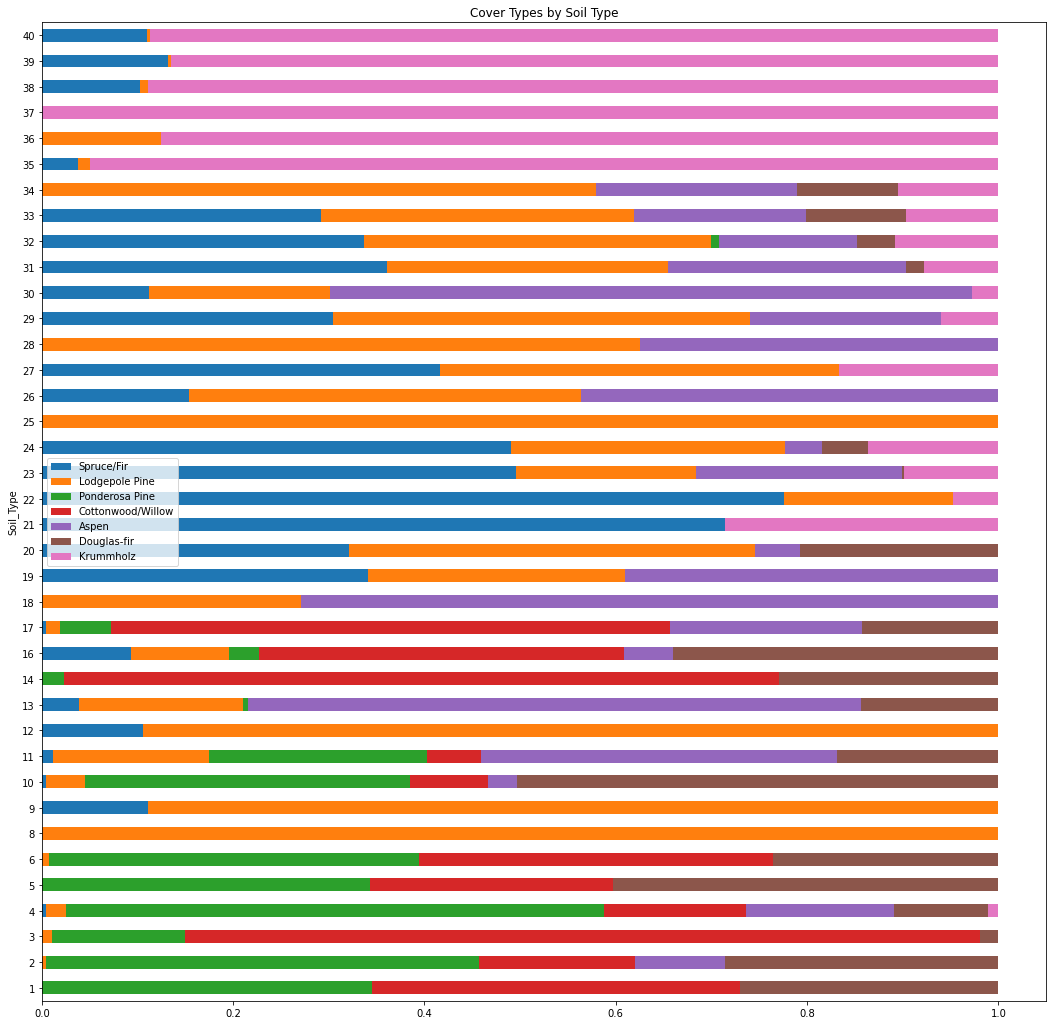

In [13]:
ct = pd.crosstab(data_chart['Soil_Type'], data_chart['Cover_Type'], normalize='index')

chart = ct.plot(kind="barh", stacked=True, rot=0, figsize=(18, 18), title='Cover Types by Soil Type')
chart.legend(CLASSES)

Continuing with what was found in the correlation matrix, we see that some cover types are only found in certain wilderness areas. The clearest example is Cottonwood/Willow which can only be found in Cache la Poudre Wilderness Area.

Something similar can be seen with soil type. Some cover types represent a really big percentage of certain soil types. For example, Krummholz makes up most of the trees with soil types from 35 to 40.

### PCA

Because this dataset contains a lot of variables, we wondered whether performing PCA with two components and visualizing the results would give us a good understanding on how clear the clusters are, and which Cover Types would be the hardest to distinguish from each other.

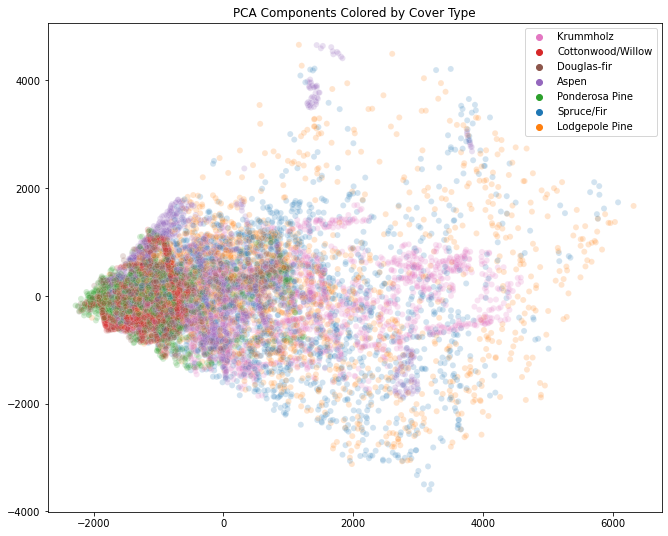

In [14]:
# Performing PCA on the training data.
pca = PCA(n_components=2)
components = pca.fit_transform(x_train)

# Getting a list of the y_train labels to use for plot colors.
hues = [CLASSES[x-1] for x in y_train]
palette = {x: y for x,y in zip(CLASSES, sns.color_palette().as_hex()[:7])}

# Plotting the data on a scatterplot.
fig, ax = plt.subplots(figsize=(11, 9))
sns.scatterplot(
    x=components[:, 0],
    y=components[:, 1],
    alpha=0.2,
    hue=hues,
    palette=palette,
    ax=ax
).set(
    title='PCA Components Colored by Cover Type'
)
plt.show()

After creating this visualization, we thought that if we transformed and rotated the data then we might be able to get a more clear idea of what's going on. 

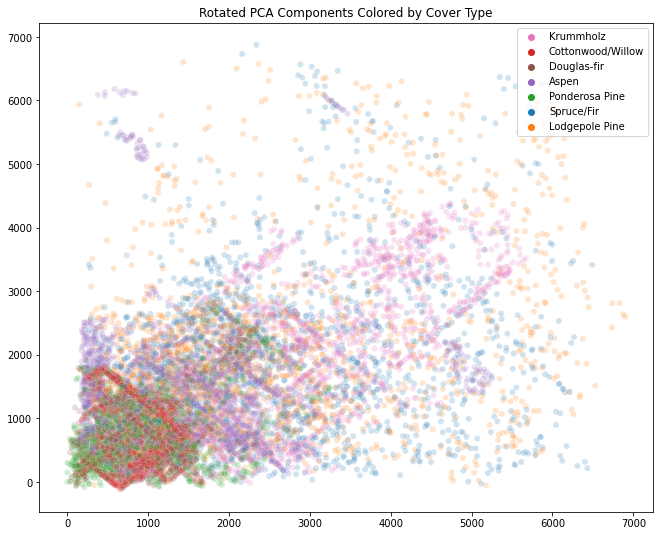

In [15]:
# There's a clear origin to pivot around, and it can be found at the minimum value for component one.
origin = [min(components[:,0]),
          components[:,1][np.where(components[:,0] == min(components[:,0]))][0]]

# Shift data points according to origin.
data = np.array([[data_point[0] - origin[0], data_point[1] - origin[1]] for data_point in components])

# Make rotation matrix.
theta = np.radians(-34) # Decided on this angle after trial and error.
cosine = np.cos(theta)
sine = np.sin(theta)
rotation_matrix = np.array(((cosine, -sine), (sine, cosine)))

# Rotate data vector.
rotated_data = data.dot(rotation_matrix)

# Plotting the rotated data on a scatterplot.
fig, ax = plt.subplots(figsize=(11, 9))
scatter_plot = sns.scatterplot(
    x=rotated_data[:, 0],
    y=rotated_data[:, 1],
    alpha=0.2,
    hue=hues,
    palette=palette,
    ax=ax
)

scatter_plot.set(
    title='Rotated PCA Components Colored by Cover Type'
)

plt.show()

The data looks much more clear after that transformation. However, the rotated data for the various cover types overlaps quite a bit. It would be helpful for interpretation to also split the scatterplots up and visualize each cover type separately.

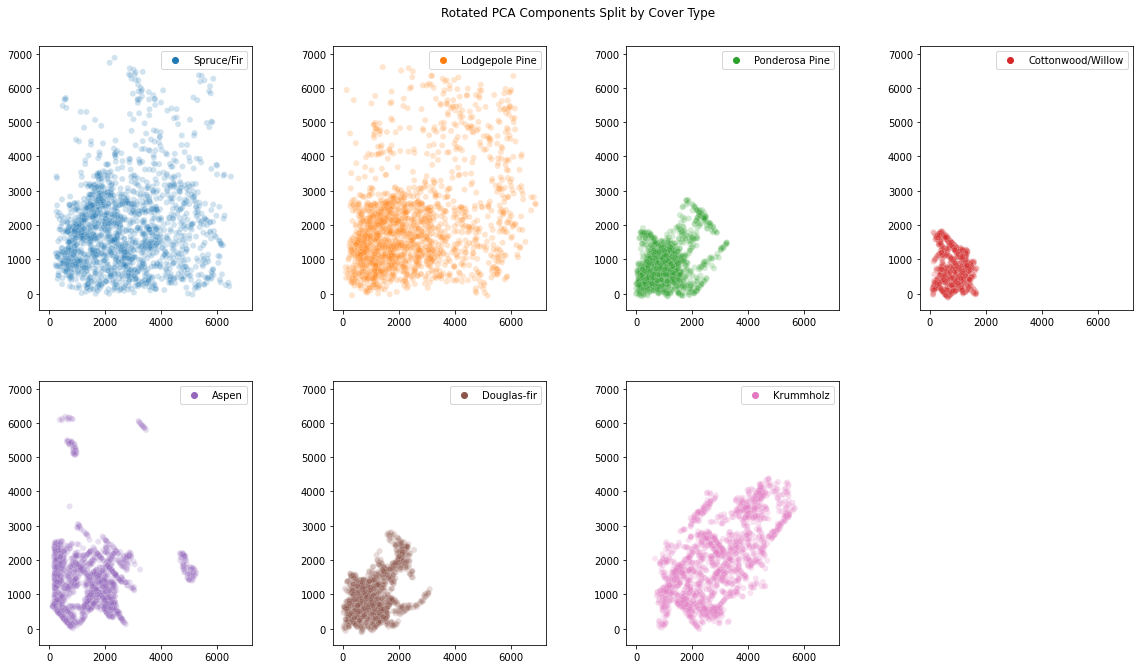

In [16]:
# Need to ensure that each plot uses the same x limit, y limit, and colors as the above plot.
y_lim = scatter_plot.get_ylim()
x_lim = scatter_plot.get_xlim()
colors = sns.color_palette().as_hex()[:7]

# Setup for the plot.
fig, ax = plt.subplots(ncols=4, nrows=2, figsize=(17, 10))
fig.suptitle('Rotated PCA Components Split by Cover Type')
fig.tight_layout(pad=5)

# Iterating through each cover type.
for x in range(1, 8):
  row_num = 0 if x < 5 else 1
  this_cover_rotated_data = rotated_data[np.where(y_train == x)]
  label = CLASSES[x - 1]
  labels = [label] * len(this_cover_rotated_data)
  palette = {label: colors[x-1]}
  sns.scatterplot(
      x=this_cover_rotated_data[:, 0],
      y=this_cover_rotated_data[:, 1],
      alpha=0.2,
      hue=labels,
      palette=palette,
      ax=ax[row_num, (x - 1) % 4]
  ).set(
      ylim=y_lim,
      xlim=x_lim
  )

# Last plot is unused.
fig.delaxes(ax[1, 3])

Based on these plots, we can tell that Spruce/Fir and Lodgepole Pine both have similar, spread out distributions and might be easy to confuse with one another. Along with that, Ponderosa Pine and Douglas-Fir both have extremely similar distributions and also might be hard to differentiate. The rest of the scatterplots seem distinct enough that it shouldn't be too hard for a model to distinguish between.

## Data Cleaning

### Check for Nulls

In [17]:
# Check for nulls in training features.
x_train.isna().sum().sum()

0

In [18]:
# Check for nulls in labels.
y_train.isna().sum().sum()

0

There are no null values in the either the training data or the testing dataset to worry about.

### Scale Continuous Columns

In [19]:
scaler = StandardScaler()

# Subtract mean and scale to unit variance for train and test.
x_train[CONTINOUS_COLUMNS] = scaler.fit_transform(x_train[CONTINOUS_COLUMNS])
x_test[CONTINOUS_COLUMNS] = scaler.transform(x_test[CONTINOUS_COLUMNS])

## Modeling

### Model Creation

The choice of model for this classification task is the Random Forest Model. The reason this model has been chosen is because of the interpretability that it provides. We are able to visualize some of the decision trees within the forest to better understand how the features that we have affect the type of forest cover that is present in that area. This model is also very fast to train and can provide great accuracy. We will use a grid search to aid in hyperparameter tuning this model. The validation set will be used to determine which hyperparamters are used when evaluting the training model on the test data.

In [28]:
# Hyperparamters to be explored when fitting the model with the Grid Seach. 
paramters = {
    'n_estimators': (10, 20, 40, 100, 200, 500),
    'criterion': ["gini", "entropy"],
    'max_depth': (None, 2, 3, 5, 10)
}

# Classifier instance.
rf = RandomForestClassifier()

# Create GridSearch instance with parameters.
clf = GridSearchCV(rf, paramters, scoring='accuracy', n_jobs=-1, cv=ps)

# Fit model.
clf.fit(x_train, y_train)


GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': (None, 2, 3, 5, 10),
                         'n_estimators': (10, 20, 40, 100, 200, 500)},
             scoring='accuracy')

#### Decision Tree Interpretation


In [ ]:
# Extract single tree from forest.
estimator = clf.best_estimator_[0]

from sklearn.tree import export_graphviz
# Export as dot file.
export_graphviz(estimator, out_file='tree.dot', 
                feature_names = dataset.columns.drop('Cover_Type'),
                class_names = CLASSES,
                rounded = True, proportion = False, 
                precision = 2, filled = True)

# Convert to png using system command.
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'tree.png')

### Model Evaluation

#### Metric Of Measurement
The main metric of measurement that we will be looking at is accuracy. Within this dataset, there are no downsides to misclassifying a label positively or negatively. Thus, we will not consider precision, recall, or F1-score as our main indictor during model evalution. While these measurements are helpful in evaluting the model, they are outweighed by the overall accuracy of the model.

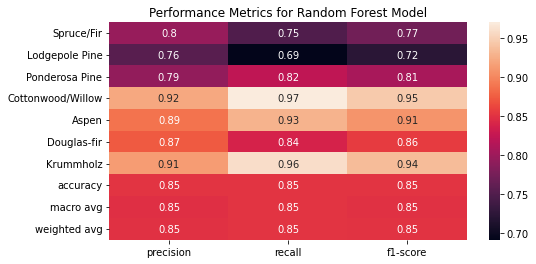

In [30]:
# Get predictions.
y_pred = clf.best_estimator_.predict(x_test)

# create classification report
clf_report = classification_report(y_test,
                                   y_pred,
                                   target_names=CLASSES,
                                   output_dict=True)

# plot classifcation report 
fig, ax = plt.subplots(figsize=(8,4))
sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True, ax=ax)
ax.set_title("Performance Metrics for Random Forest Model")
plt.show()

Using a simple random forest with the default hyperparamter configurations, we are able to achieve an accuracy of 85%. This is a very good accuracy for a starting point and can be further improved through hyperparamter tuning. One thing to note is that the F1-score for the Spruce/Fir and Lodgepole Pine is a fair amount lower compared to the other classes. It is possible that there may need to be some futher exploration into the data for the classes to see what is causing this lowered F1-score.

#### Error Analysis

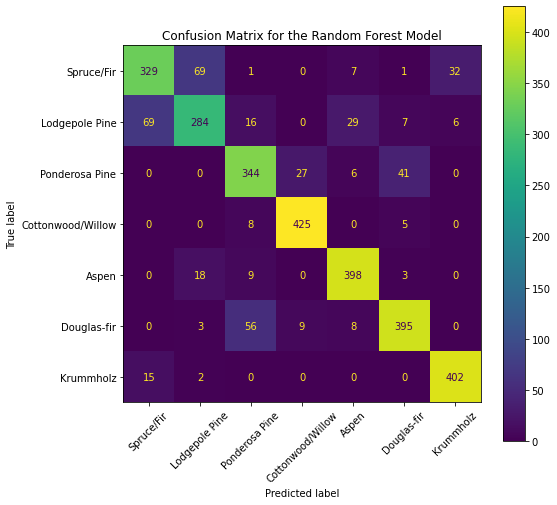

In [34]:
# plot confusion matrix
fig, ax = plt.subplots(figsize=(8,8))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=ax)
tick_marks = np.arange(len(CLASSES))
ax.set_xticks(tick_marks)
ax.set_xticklabels(CLASSES, rotation=45)
ax.set_yticks(tick_marks)
ax.set_yticklabels(CLASSES)
ax.set_title("Confusion Matrix for the Random Forest Model")
plt.show()

In the confusion matrix, one thing that stands out is the misclassfication between Spruce/Fir and Lodgepole Pine. This is supported by the lower F1-score that we saw for these classes earlier. It seems that the model struggles the most to differentiate between these two classes.